<h1><center><font size='25'>U.S Stock Market Price Forecasting with Skforecast package</font></center></h1>

<center><b>Son Hai Le, Inspired by <a href="https://www.cienciadedatos.net/documentos/py41-forecasting-cryptocurrency-bitcoin-machine-learning-python.html">the Article of Joaquín Amat Rodrigo, Javier Escobar Ortiz</a> </b></center>


<center><i>March, 2023 (last update September, 2023)</i></center>

+ [Web apps: U.S finance dashboard](https://lhs-inc-us-finance-investigation.streamlit.app/)
+ [Skforecast: time series forecasting with Python and Scikit-learn](https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html)
+ [Forecasting electricity demand with Python](https://www.cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python.html)
+ [Forecasting web traffic with machine learning and Python](https://www.cienciadedatos.net/documentos/py37-forecasting-web-traffic-machine-learning.html)
+ [Forecasting time series with gradient boosting: Skforecast, XGBoost, LightGBM and CatBoost](https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html)
+ [Prediction intervals in forecasting models](https://www.cienciadedatos.net/documentos/py42-forecasting-prediction-intervals-machine-learning.html)

## Introduction
<br>

A time series is a succession of chronologically ordered data spaced at equal or unequal intervals. The [forecasting](https://joaquinamatrodrigo.github.io/skforecast/latest/quick-start/introduction-forecasting.html) process consists of predicting the future value of a time series, either by modeling the series solely based on its past behavior (autoregressive) or by using other external variables.

When creating a forecaster model, historical data are used to get a mathematical representation capable of predicting future values. This idea is based on a very important assumption: **the future behavior of a phenomenon can be explained from its past behavior**. However, this rarely happens in reality, or at least not in its entirety. For more on this, see the following definition:

<p style="text-align: center;"> $Forecast = pattern + unexplained\;variance$ </p>

The first term of the equation refers to everything that has a repetitive character over time (trend, seasonality, cyclical factors...). The second term represents everything that influences the response variable but is not captured (explained) by the past of the time series.

The greater the importance of the first term relative to the second, the greater the probability of success when attempting to create autoregressive forecasting models. As the second term gains weight, it becomes necessary to incorporate additional variables (if any) into the model to help explain the observed behavior.

A good study of the modeled phenomenon and the ability to recognize to what extent its behavior can be explained by its past can save a lot of unnecessary effort.

This document shows an example of how to identify situations where the autoregressive forecasting process cannot achieve useful results. As an example, an attempt to predict the daily closing price of Bitcoin using machine learning methods is made. For this purpose, [**Skforecast**](https://joaquinamatrodrigo.github.io/skforecast/latest/index.html) is used, a simple Python library that allows, among other things, to adapt any **Scikit-learn** regressor to forecasting problems.
<br>

## Use Case
<br>

<img src='./images/btc.png' style='width: 100px; padding-right: 20px; padding-left: 15px; padding-top: 5px' align='left'>

[Bitcoin](https://en.wikipedia.org/wiki/Bitcoin) (₿) is a decentralized cryptocurrency that can be sent from one user to another through the bitcoin peer-to-peer network without intermediaries. Transactions are verified and recorded in a public distributed ledger called Blockchain. Bitcoins are created as a reward for a process known as [mining](https://en.wikipedia.org/wiki/Bitcoin#Mining) and can be exchanged for other currencies, products, and services.

Although there may be different opinions about Bitcoin, whether as a high-risk speculative asset or, on the other hand, as a store of value, it is undeniable that it has become one of the most valuable financial assets globally. The website [Infinite Market Cap](https://8marketcap.com/) shows a list of all financial assets ranked by market capitalization. Bitcoin, at the time of writing, is in the top 10. It is close to world-renowned companies such as Tesla or globally accepted safe-haven assets such as silver. The growing interest in Bitcoin, and the world of cryptocurrencies, makes it an interesting phenomenon to model.

The aim is to generate a forecasting model capable of predicting the price of Bitcoin. A time series is available with the opening (Open), closing (Close), maximum (High), and minimum (Low) prices of Bitcoin in US dollars (USD) from 2013-04-28 to 2022-01-01.
<br><br>

## Libraries
<br>

The libraries used in this document are:

In [1]:
# Data manipulation
# ==============================================================================
import pandas as pd
import numpy as np
import datetime
# from cryptocmd import CmcScraper

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('ggplot')

# Bitcoin colors
# ==============================================================================
palette_btc = {'orange': '#f7931a',
               'white' : '#ffffff',
               'gray'  : '#4d4d4d',
               'blue'  : '#0d579b',
               'green' : '#329239'
              }

# Modelling and Forecasting
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

## Data
<br>

The data download is performed using [cryptocmd](https://openbase.com/python/cryptocmd). This library is useful for downloading historical cryptocurrency data from the [Coinmarketcap](https://coinmarketcap.com/) website. The information in each column is:

+ `Date`: date of the record.

+ `Open`: the opening price, the price at which an asset, in this case, Bitcoin, trades at the beginning of the day. (USD).

+ `High`: the maximum price of the day, the highest price reached by Bitcoin on that day, (USD).

+ `Low`: the minimum price of the day, the lowest price reached by the Bitcoin on that day, (USD).

+ `Close`: the closing price, the price at which Bitcoin trades at the end of the day, (USD).

+ `Volume`: the sum of actual trades made during the day, (USD).

+ `Market Cap`: market capitalization, the total value of all shares of a company or, in the case of Bitcoin or another cryptocurrency, of all coins in circulation, (USD).

*Note: the cryptocurrency market is uninterrupted. It operates 24 hours a day, 7 days a week. However, it is not strictly necessary that the close price coincides with the open price of the next day because of the fluctuations that the value of Bitcoin, or any cryptocurrency, may undergo during the last second of the day.*

In [61]:
# Data open
# ==============================================================================

# Transform collected data into a dataframe
data = pd.read_csv('MMM_price_history.csv')
data.sort_values(by='date', ascending=True, inplace=True)

pd.set_option('display.max_columns', None)
display(data)
pd.reset_option('display.max_columns')

,date,open,high,low,close,volume,adjclose,dividends
0,2013-04-29,103.910004,104.199997,102.889999,103.830002,2903700,77.111168,0.0
1,2013-04-30,103.980003,104.739998,102.970001,104.709999,3768800,77.764679,0.0
2,2013-05-01,104.779999,105.120003,104.419998,104.550003,3258900,77.645897,0.0
3,2013-05-02,105.040001,106.379997,104.910004,106.040001,3119500,78.752449,0.0
4,2013-05-03,106.959999,108.599998,106.849998,107.830002,3013100,80.081795,0.0
...,...,...,...,...,...,...,...,...
2182,2021-12-27,175.149994,176.729996,174.910004,176.699997,1183000,167.297440,0.0
2183,2021-12-28,176.839996,178.500000,176.750000,177.639999,1618900,168.187408,0.0
2184,2021-12-29,177.479996,178.889999,177.229996,178.410004,1221900,168.916458,0.0
2185,2021-12-30,178.869995,179.179993,177.580002,177.639999,1067300,168.187408,0.0


In [62]:
# Data preparation
# ==============================================================================
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')
# data = data.loc[:, ['date', 'Open', 'Close', 'High', 'Low']]
# data = data.rename({'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low'}, 
#                     axis=1)
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()
data.fillna(method='ffill', inplace=True)


When setting a frequency with the `asfreq()` method, **Pandas** fills the gaps that may exist in the time series with the value of `Null` to ensure the indicated frequency. Therefore, it should be checked if missing values have appeared after this transformation.

In [63]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')
# find rows with missing values
# mask = data.isnull().any(axis=1)
# rows_with_missing_values = data[mask]
# print(rows_with_missing_values)

Number of rows with missing values: 0.0


## Graphic exploration
<br>

When it is necessary to generate a forecasting model, plotting the time series values could be useful. This allows identifying patterns such as trends and seasonality.

### Candlestick chart

A [candlestick chart](https://en.wikipedia.org/wiki/Candlestick_chart) is a style of financial chart used to describe price movements of a security, derivative, or currency. The thick body shows the variation between the opening and closing price for a period, while the shadows show the minimum and maximum values reached during that period.

<center><img src="https://en.wikipedia.org/wiki/Candlestick_chart#/media/File:Candlestick_chart_scheme_03-en.svg" style='width: 300px; padding-bottom: 5px' align='center'></center>

<center><font size='2.5'> <i>Scheme of the 2 kinds of basic candlestick chart. Source: <a href="https://en.wikipedia.org/wiki/Candlestick_chart#/media/File:Candlestick_chart_scheme_03-en.svg">Wikipedia</a>.</i></font></center>

In [31]:
# Interactive candlestick chart with Plotly
# ==============================================================================
candlestick = go.Candlestick(
                  x     = data.index,
                  open  = data.open,
                  close = data.close,
                  low   = data.low,
                  high  = data.high,
              ) 

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 900,
    height      = 450,
    title       = dict(text='<b>MMM/USD Chart</b>', font=dict(size=30)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=15)),
    margin      = dict(l=10, r=20, t=80, b=20),
    xaxis_rangeslider_visible = False,
)

fig.show()

### Data distribution

The distribution of the Bitcoin closing price, variable `close`, is shown:

Text(0.5, 0, 'Price (USD)')

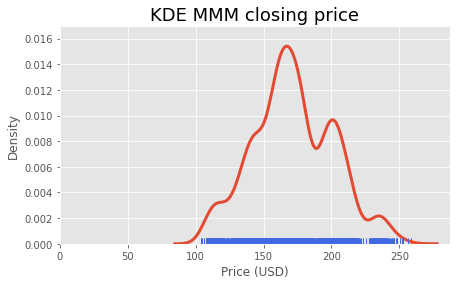

In [37]:
# KDE distribution of Bitcoin closing price
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 4))
p = sns.kdeplot(data=data, x='close', linewidth=3, ax=ax)
r = sns.rugplot(data=data, x='close', ax=ax,c='royalblue', clip_on=False)
p.set(xlim=(0, None))
p.set_title('KDE MMM closing price', fontsize=18)
p.set_xlabel('Price (USD)')

The study data shows a majority distribution of prices below 20,000 (USD). This stage corresponds to the period between 2013 and September 2020. Since 2021, the price has been in the range of 35,000 - 67,500 (USD).

Trying to model a time series with a highly asymmetric distribution and distinct orders of magnitude over time can cause complications. One strategy is model changes (deltas) rather than direct values to minimize these problems. It could be further simplified, indicating only whether the price increases or decreases from the previous day.

*Note: when a distribution is asymmetric, modeling deltas instead of price may result in a more symmetric distribution.*

In [11]:
# Create deltas column (% change)
# ==============================================================================
# data['change_pct'] = 100*(data['close'] - data['open']) / data['open']
# # With Pandas pct_change() method
# data['change_pct'] = data.pct_change(axis='columns').iloc[:, 1]*100
# data.head(2)

### Price per year

In [42]:
# Locate corresponding data for each year
# ==============================================================================
years = list(data.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
    
    year_open  = data.loc[data.index.year == year, 'open'][0]
    year_close = data.loc[data.index.year == year, 'close'][-1]
    year_low   = data.loc[data.index.year == year, 'low'].min()
    year_high  = data.loc[data.index.year == year, 'high'].max()
    
    df_plot[year] = pd.Series([year_open, year_close, year_low, year_high]) 
    
df_plot = df_plot.T
df_plot = df_plot.set_axis(['open', 'close', 'low', 'high'], axis=1)

# Calculate % change between the open and close price of the year
# ==============================================================================
df_plot['year_change'] = 100*(df_plot['close'] - df_plot['open']) / df_plot['open']
df_plot.head(3)

,open,close,low,high,year_change
2013,103.910004,140.250000,102.889999,140.429993,34.972568
2014,138.050003,164.320007,123.610001,168.160004,19.029340
2015,164.710007,150.639999,134.000000,170.500000,-8.542291


In [44]:
# Create a list of dicts with the % change annotations for the plot
# ==============================================================================
annotations_list = []
max_high = df_plot['high'].max()

for year in years:
    
    df_aux = df_plot.loc[df_plot.index == year,]
    loc_x  = pd.to_datetime(df_aux.index[0], format='%Y')
    loc_y  = df_aux['high'].values[0]/max_high + 0.01
    text   = '{:.1f}%'.format(df_aux['year_change'].values[0])
    
    annotation = dict(x=loc_x, y=loc_y, 
                      xref='x', yref='paper',
                      showarrow=False, xanchor='center', 
                      text=text)

    annotations_list.append(annotation)

# Interactive candlestick chart with Plotly
# ==============================================================================
candlestick = go.Candlestick(
                  x     = pd.to_datetime(df_plot.index, format='%Y'),
                  open  = df_plot.open,
                  close = df_plot.close,
                  low   = df_plot.low,
                  high  = df_plot.high
              )

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 800,
    height      = 350,
    title       = dict(text='<b>MMM/USD yearly chart</b>', font=dict(size=25)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20),
    xaxis_rangeslider_visible = False,
    annotations = annotations_list
)

fig.show()

### Annual, monthly and weekly seasonality

In [45]:
# Locate corresponding data for each month
# ==============================================================================
years = list(data.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
    for month in range(12):
        
        start_date = pd.to_datetime(f'{year}-{month+1}-01', format='%Y-%m-%d')
        end_date = (start_date + pd.offsets.MonthBegin())
        mask = (data.index >= start_date) & (data.index < end_date)
        
        if not data.loc[mask, :].empty:
                        
            month_open  = data.loc[mask, 'open'][0]
            month_close = data.loc[mask, 'close'][-1]
            month_low   = data.loc[mask, 'low'].min()
            month_high  = data.loc[mask, 'high'].max()
            
            serie  = pd.Series([month_open, month_close, month_low, month_high])
            df_aux = pd.DataFrame(serie, columns=[f'{str(month+1).zfill(2)}-{year}'])
            
            if df_plot.empty:
                df_plot = df_aux.copy()
            else:
                df_plot = pd.concat([df_plot, df_aux], axis=1)

df_plot = df_plot.T
df_plot = df_plot.set_axis(['open', 'close', 'low', 'high'], axis=1)

In [46]:
# Boxplot chart for annual seasonality
# ==============================================================================
# df_plot['month'] = pd.to_datetime(df_plot.index, format='%m-%Y').month
# fig, ax = plt.subplots(figsize=(7, 3.5))
# df_plot.boxplot(column='close', by='month', ax=ax)
# df_plot.groupby('month')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Price (USD)')
# ax.set_title('BTC Price per month')
# fig.suptitle('');

df_plot['month'] = pd.to_datetime(df_plot.index, format='%m-%Y').month

# fig 1 monthly boxplot
fig1 = px.box(df_plot.sort_values('month'), x='month', y='close',
              color_discrete_sequence=[palette_btc['green']])

# fig 2 line with median data for each month
df_median = pd.DataFrame(df_plot.groupby('month')['close'].median()).reset_index()
fig2 = px.line(df_median, x='month', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gray']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>MMM Price per month</b>', font=dict(size=25)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='month', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)

fig.show()

In [47]:
# Boxplot chart for monthly seasonality
# ==============================================================================
# fig, ax = plt.subplots(figsize=(9, 3.5))
# data['day'] = pd.Series(data.index).dt.day.values
# data.boxplot(column='close', by='day', ax=ax)
# data.groupby('day')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Price (USD)')
# ax.set_title('BTC Price per day of the month')
# fig.suptitle('');

data['day'] = pd.Series(data.index).dt.day.values

# fig 1 dayly boxplot
fig1 = px.box(data.sort_values('day'), x='day', y='close',
              color_discrete_sequence=[palette_btc['green']])

# fig 2 line with median data for each day
df_median = pd.DataFrame(data.groupby('day')['close'].median()).reset_index()
fig2 = px.line(df_median, x='day', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gray']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 750,
    height      = 350,
    title       = dict(text='<b>MMM Price per day of the month</b>', font=dict(size=25)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear', tickangle=0, range=[0.5, 31.5]),
    xaxis_title = dict(text='day', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)

fig.show()

In [49]:
# Boxplot chart for weekly seasonality
# ==============================================================================
# fig, ax = plt.subplots(figsize=(7, 3.5))
# data['weekday'] = data.index.day_of_week + 1
# data.boxplot(column='close', by='weekday', ax=ax)
# data.groupby('weekday')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Price (USD)')
# ax.set_title('BTC Price per day of the week');

data['weekday'] = data.index.day_of_week + 1

# fig 1 weekly boxplot
fig1 = px.box(data.sort_values('weekday'), x='weekday', y='close',
              color_discrete_sequence=[palette_btc['green']])

# fig 2 line with median data for each weekday
df_median = pd.DataFrame(data.groupby('weekday')['close'].median()).reset_index()
fig2 = px.line(df_median, x='weekday', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gray']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>MMM Price per day of the week</b>', font=dict(size=25)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='weekday', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)

fig.show()

Usually, time series with an autoregressive pattern produce a repetitive shape (trend, seasonality, cyclical factors). Regarding Bitcoin, a certain annual seasonality appears at the end and beginning of the year, with larger variations in price. No seasonality appears in the monthly and weekly intervals, with very similar distributions.

### Autocorrelation plots

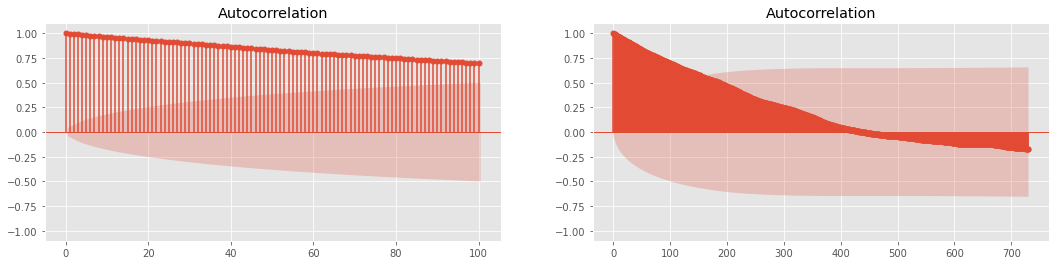

In [50]:
# Autocorrelation plot
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_acf(data.close, ax=axes[0], linewidth = 1, lags=100)
axes[0].set_ylim(-1.1, 1.1)
plot_acf(data.close, ax=axes[1], linewidth = 1, lags=730)
axes[1].set_ylim(-1.1, 1.1)
plt.show()

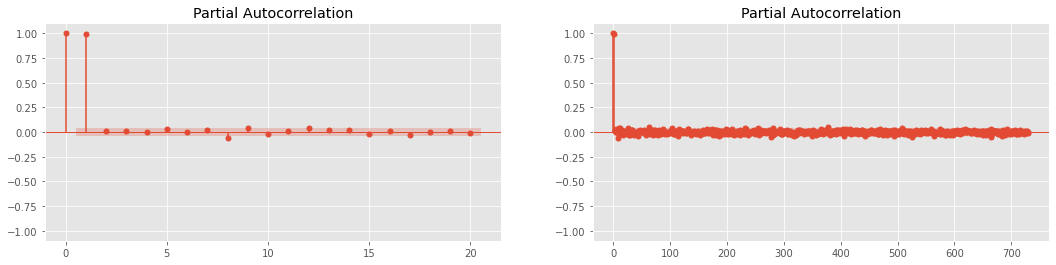

In [51]:
# Partial autocorrelation plot
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_pacf(data.close, ax=axes[0], lags=20, method='ywm',  linewidth = 1)
axes[0].set_ylim(-1.1, 1.1)
plot_pacf(data.close, ax=axes[1], lags=730, method='ywm',  linewidth = 1)
axes[1].set_ylim(-1.1, 1.1)
plt.show()

The autocorrelation plots show that lag 1 is the only one correlated with lag 0. The following lags do not exceed the significance threshold.

## Baseline - Random walk simulation
<br>

When generating a predictive model, it is convenient to identify a base model, or baseline, on which to compare each of the proposed iterations or models. In the case of finance, according to [random walk theory](https://en.wikipedia.org/wiki/Random_walk_hypothesis), market prices behave randomly and not as a function of their time series. Thus, the best estimate of the value $t_{n+1}$ is the value $t_{n}$ plus an unpredictable change.

Although a broad time series is available, it presents periods with highly differentiated prices, as determined in the graphical exploration. Only data from the **last two years** are used.

In [52]:
# Selection of train-test dates
# ==============================================================================
start_train = '2020-01-01'
end_train = '2021-06-30'

print(f"Complete time series : {data.index.min()} --- {data.index.max()}  (n={len(data)})")
print(f"Train dates          : {data.loc[start_train:end_train].index.min()} --- {data.loc[start_train:end_train].index.max()}  (n={len(data.loc[start_train:end_train])})")
print(f"Test dates           : {data.loc[end_train:].index.min()} --- {data.loc[end_train:].index.max()}  (n={len(data.loc[end_train:])})")

Complete time series : 2013-04-29 00:00:00 --- 2021-12-31 00:00:00  (n=2187)
Train dates          : 2020-01-02 00:00:00 --- 2021-06-30 00:00:00  (n=377)
Test dates           : 2021-06-30 00:00:00 --- 2021-12-31 00:00:00  (n=129)


As mentioned above, random walk suggests that the best estimate for the $t_{n+1}$ value is the $t_{n}$ value plus an unpredictable change. Therefore, the simplest viable model uses the value of $t_{n}$ as the prediction for the $t_{n+1}$ value. It is set as the baseline model.

In [64]:
# Random walk simulation
# ==============================================================================
df_rw = data[['close']].copy()
df_rw['pred_close'] = df_rw['close'].shift(1)

# Test error
# ==============================================================================
y_true = df_rw.loc[end_train:, 'close']
y_pred = df_rw.loc[end_train:, 'pred_close']
metric = mean_absolute_error(y_true, y_pred)

print(f'Test error: {metric}')
display(df_rw.loc[end_train:,].head(4))

Test error: 1.0259457150021125


,close,pred_close
date,,
2021-06-30,198.630005,196.029999
2021-07-01,199.089996,198.630005
2021-07-02,199.889999,199.089996
2021-07-03,199.889999,199.889999


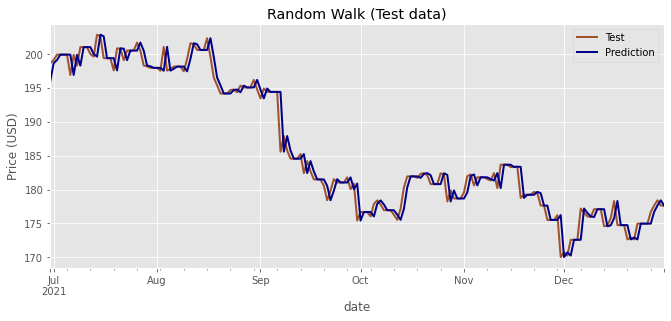

In [65]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4.5))
df_rw.loc[end_train:, 'close'].plot(ax=ax, linewidth=2, label='Test',
                                    c='sienna')
df_rw.loc[end_train:, 'pred_close'].plot(ax=ax, linewidth=2, label='Prediction',
                                    c='darkblue')
ax.set_title('Random Walk (Test data)')
ax.set_ylabel('Price (USD)')
ax.legend()

In [66]:
# DataFrame models' test error
# ==============================================================================
df_errors = pd.DataFrame({'model': 'Base - Random Walk', 'lags': 1, 
                          'test_error': metric, 'exog_variables': False},
                         index=[0])
df_errors

,model,lags,test_error,exog_variables
0,Base - Random Walk,1,1.025946,False


The model test error is 1,267.8. The following sections intend to generate a model capable of reducing this error.

## Recursive autoregressive forecaster
<br>

An Autoregressive Forecaster ([ForecasterAutoreg](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/autoregresive-forecaster.html)) with a [LightGBM](https://lightgbm.readthedocs.io/en/latest/) regressor, an implementation of the **Gradient Boosting** algorithm developed by Microsoft that usually achieves excellent results, is used to model the Bitcoin price.

Previous sections show an absence of autocorrelation beyond the first lag. One way to verify this is to train several models with an increasing amount of lags and check if the error doesn't reduce. This approach can be done by [*backtesting*](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/backtesting.html), using `steps = 1` (predict only the next value in the series, $t_{n+1}$) it reproduces the random walk model methodology. 

*Note: It is not rigorously necessary to perform any data preprocessing when working with models based on decision trees (`StandardScaler`, `MinMaxScaler`...). [Example of forecasting with Scikit-learn pipelines](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/sklearn-transformers-and-pipeline.html).*

In [67]:
# Forecasters backtest with different lags
# ==============================================================================
lags = [1, 7, 30]
metrics = []
predictions_list = []

for lag in lags:
    
    # Create forecaster
    forecaster = ForecasterAutoreg(
                     regressor     = LGBMRegressor(random_state=123),
                     lags          = lag,
                     transformer_y = None
                 )
    
    # Backtest test data, 1 step
    metric, predictions = backtesting_forecaster(
                              forecaster         = forecaster,
                              y                  = data.loc[start_train:, 'close'],
                              initial_train_size = len(data.loc[start_train:end_train, 'close']),
                              fixed_train_size   = True,
                              steps              = 1,
                              refit              = True,
                              metric             = 'mean_absolute_error',
                              verbose            = False
                          )
    
    metrics.append(metric)
    predictions_list.append(predictions)

c:\Users\84163\AppData\Local\Programs\Python\Python38\lib\site-packages\skforecast\model_selection\model_selection.py:370: RuntimeWarning:

The forecaster will be fit 184 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 


c:\Users\84163\AppData\Local\Programs\Python\Python38\lib\site-packages\skforecast\model_selection\model_selection.py:370: RuntimeWarning:

The forecaster will be fit 184 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 


c:\Users\84163\AppData\Local\Programs\Python\Python38\lib\site-packages\skforecast\model_selection\model_selection.py:370: RuntimeWarning:

The forecaster will be fit 184 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




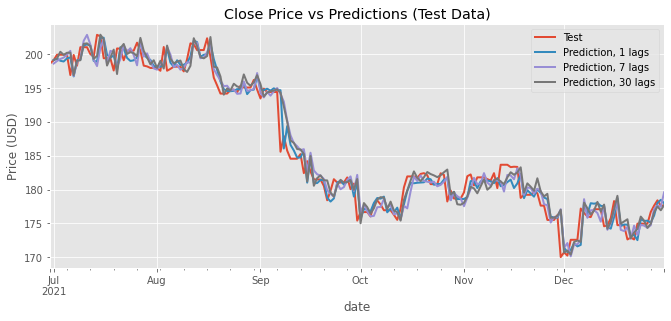

In [68]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4.5))
data.loc[end_train:, 'close'].plot(ax=ax, linewidth=2, label='Test')

# Plot test predictions for different lags
for predictions, lag in zip(predictions_list, lags):
    predictions = predictions.rename(columns={'pred': f'Prediction, {lag} lags'})
    predictions.plot(ax=ax, linewidth=2)

ax.set_title('Close Price vs Predictions (Test Data)')
ax.set_ylabel('Price (USD)')
ax.legend()

In [69]:
# DataFrame models' test error
# ==============================================================================
model = 'LGBMRegressor'

df_errors = pd.concat([
                df_errors,
                pd.DataFrame({'model': model, 'lags': lags, 
                              'test_error': metrics, 'exog_variables': False})
                ]).reset_index(drop=True)

df_errors.sort_values(by='test_error')

,model,lags,test_error,exog_variables
0,Base - Random Walk,1,1.025946,False
1,LGBMRegressor,1,1.302892,False
3,LGBMRegressor,30,1.386864,False
2,LGBMRegressor,7,1.394841,False


The **test errors** (which reflect how well each model generalizes) show that none of the models improves the baseline despite incorporating more information from the past (number of lags). Because of the results, other alternatives are tested, such as incorporating exogenous variables into the series.

## Forecasting with exogenous variables
<br>

In the previous example, only lags of the predicted variable itself have been used as predictors. In some scenarios, it is possible to have information about other variables, **whose future value is known**, and which can serve as additional predictors in the model. Typical examples are:

+ Holidays (local, national...)

+ Month of the year

+ Day of the week

+ Time of day

For this case, it is used the variables resulting from the section about Bitcoin halving and, after studying seasonality, the month of the year.

*Note: The `reward` and `month` variables, although encoded as numbers, are categorical, so it is convenient to change the type with which they are stored. Since these variables do not have many levels, the One Hot Encoding transformation is used to incorporate them into the model.*

In [70]:
# Change of the categorical variables to category type
# ==============================================================================
data['month'] = data.index.month
data['month'] = data['month'].astype('category')

# One hot encoding
data = pd.get_dummies(data, columns=['month'])
data.head(2)

,open,high,low,close,volume,adjclose,dividends,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,,,,,,
2013-04-29,103.910004,104.199997,102.889999,103.830002,2903700.0,77.111168,0.0,0,0,0,1,0,0,0,0,0,0,0,0
2013-04-30,103.980003,104.739998,102.970001,104.709999,3768800.0,77.764679,0.0,0,0,0,1,0,0,0,0,0,0,0,0


In [71]:
# All exogenous variables are selected, including those obtained  
# during one hot encoding.
# ==============================================================================
exog = [column for column in data.columns if column.startswith(('month'))]
print(exog)

['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']


In [72]:
# Forecaster backtest with exogenous variables
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = LGBMRegressor(random_state=123),
                 lags             = 1,
                 transformer_y    = None,
                 transformer_exog = None
             )

# Backtest test data, 1 step
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data.loc[start_train:, 'close'],
                          exog               = data.loc[start_train:, exog],
                          initial_train_size = len(data.loc[start_train:end_train, 'close']),
                          fixed_train_size   = True,
                          steps              = 1,
                          refit              = True,
                          metric             = 'mean_absolute_error',
                          verbose            = False
                      )

c:\Users\84163\AppData\Local\Programs\Python\Python38\lib\site-packages\skforecast\model_selection\model_selection.py:370: RuntimeWarning:

The forecaster will be fit 184 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




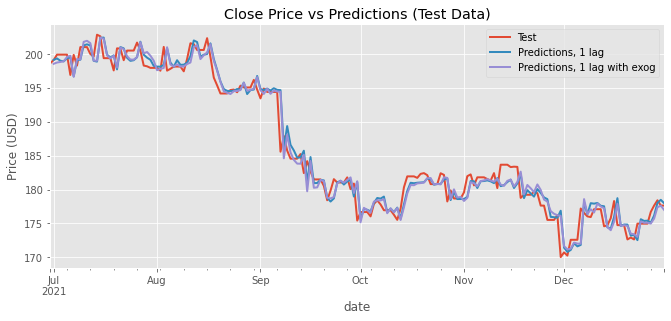

In [73]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4.5))
data.loc[end_train:, 'close'].plot(ax=ax, linewidth=2, label='Test')

# Plot predictions 1 lag without exogenous variables
predictions_no_exog = predictions_list[0].rename(columns={'pred': f'Predictions, 1 lag'})
predictions_no_exog.plot(ax=ax, linewidth=2)

# Plot predictions 1 lag with exogenous variables
predictions_exog = predictions.rename(columns={'pred': f'Predictions, 1 lag with exog'})
predictions_exog.plot(ax=ax, linewidth=2)

ax.set_title('Close Price vs Predictions (Test Data)')
ax.set_ylabel('Price (USD)')
ax.legend();

In [74]:
# DataFrame models' test error
# ==============================================================================
model = 'LGBMRegressor'

df_errors = pd.concat([
                df_errors,
                pd.DataFrame({'model': model, 'lags': 1, 
                              'test_error': metric, 'exog_variables': True},
                             index=[4])
                ]).reset_index(drop=True)

df_errors.sort_values(by='test_error')

,model,lags,test_error,exog_variables
0,Base - Random Walk,1,1.025946,False
1,LGBMRegressor,1,1.302892,False
4,LGBMRegressor,1,1.308170,True
3,LGBMRegressor,30,1.386864,False
2,LGBMRegressor,7,1.394841,False


Incorporating exogenous variables increases the predictive capacity of the model in this case. But, even so, it does not exceed that of the base model.

## Conclusions
<br>

+ Bitcoin price does not follow an autoregressive pattern. The best estimate for the $t_{n+1}$ value is the $t_{n}$ value plus an unpredictable change. Early identification of the absence of this correlation by descriptive analysis avoids unnecessary modeling efforts.

+ When a time series with no autocorrelation is available, one should look for exogenous variables capable of helping with the problem. For example, to predict the price of Bitcoin in the short term (hours), exogenous variables such as the market sentiment through the analysis of tweets, impact of the so-called key opinion leaders, analysis of the most relevant news, etc. could be used.

+ Using machine learning models in forecasting problems is very simple thanks to the functionalities offered by [**Skforecast**](https://joaquinamatrodrigo.github.io/skforecast/latest/index.html).
<br><br>

## Session information

In [32]:
import session_info
session_info.show(html=False)

-----
cryptocmd           0.6.1
ipykernel           5.5.6
lightgbm            3.3.2
matplotlib          3.5.0
numpy               1.23.0
pandas              1.4.0
plotly              5.10.0
seaborn             0.11.0
session_info        1.0.0
skforecast          0.5.0
sklearn             1.1.0
statsmodels         0.13.0
-----
IPython             8.5.0
jupyter_client      7.3.5
jupyter_core        4.11.1
notebook            6.4.12
-----
Python 3.9.13 (main, Aug 25 2022, 23:26:10) [GCC 11.2.0]
Linux-5.15.0-48-generic-x86_64-with-glibc2.31
-----
Session information updated at 2022-10-03 21:51


**How to cite this document?**

<p style="text-align:left"><font size="3" color="#555">
Bitcoin price prediction with Python, when the past does not repeat itself by Joaquín Amat Rodrigo and Javier Escobar Ortiz, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/documentos/py41-forecasting-cryptocurrency-bitcoin-machine-learning-python.html
    
</font></p>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by Joaquín Amat Rodrigo and Javier Escobar Ortiz is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.